In [27]:
import pandas as pd
import networkx as nx
from pyvis.network import Network


In [28]:
df=pd.read_csv('fraud_dataset.csv')

In [29]:
df.head()

,sender,receiver,amount,timestamp,transaction_type,location,device_type,is_foreign_transaction,time_of_day,risk_score
0,U623,U59,3610.17,2025-01-01,wire_transfer,US,ATM,0,5,0
1,U2111,U902,2617.73,2025-01-01,wire_transfer,UK,mobile,0,6,0
2,U2503,U1892,2766.80,2025-01-01,cash_deposit,Dubai,mobile,1,13,0
3,U2872,U1182,436.66,2025-01-01,online_payment,India,desktop,0,7,0
4,U2859,U175,1263.44,2025-01-01,online_payment,Germany,mobile,1,3,0


In [62]:
# Build Graph
G = nx.DiGraph()
valid_nodes = set(df["sender"].dropna()).union(set(df["receiver"].dropna()))  # Ensure only existing nodes are used
for _, row in df.iterrows():
    sender, receiver = row["sender"], row["receiver"]
    if pd.notna(sender) and pd.notna(receiver) and sender in valid_nodes and receiver in valid_nodes:
        G.add_edge(sender, receiver, weight=row["amount"])


In [63]:
# Compute centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000, tol=1e-6)
pagerank = nx.pagerank(G)

In [64]:
# Function to add nodes based on centrality rankings
def add_node_safe(net, node, color, title):
    if node in G.nodes():
        net.add_node(node, color=color, title=title)

# Function to safely add edges to Pyvis
def add_edge_safe(net, sender, receiver, title, width):
    if sender in G.nodes() and receiver in G.nodes():
        net.add_edge(sender, receiver, title=title, width=width)

---

### Scenario 1: Ponzi Scheme Detection (High Eigenvector Centrality) 

https://iclg.com/news/21624-south-african-ponzi-scammers-disbarred-for-30-years
- Eigenvector centrality measures how important a node is within a network, not just based on the number of connections (like degree centrality) but also based on the importance of the nodes it connects to.

##### How it Works
- Each node starts with an equal score.
- A node’s centrality score is higher if it is connected to high-scoring nodes.
- The calculation iterates multiple times, adjusting scores based on connections.
- Converges when scores stabilize, indicating the true importance of each node.

Why is Eigenvector Centrality Useful in Fraud Detection?
### - 📌 Ponzi Schemes:

The main orchestrators will have high eigenvector centrality because they are connected to many influential participants.
Investors at the bottom of the chain will have lower centrality scores, as they are only connected to one or two higher-level nodes.

### -📌 Money Laundering Networks:

Layered transactions (placement, layering, integration) create hidden networks.
Criminals will not always have high degree centrality, but they will be linked to highly influential intermediaries (money mules, shell companies).
### - 📌 Corporate Fraud & Embezzlement:

Key insiders who redistribute stolen funds to multiple accounts will have high eigenvector centrality.
Accounts receiving large amounts of money from high-centrality nodes should be flagged for investigation.

In [66]:

ponzi_accounts = sorted(eigenvector_centrality, key=eigenvector_centrality.get, reverse=True)[:50]

G_ponzi = nx.DiGraph()
net = Network(notebook=True, directed=True)

for sender in ponzi_accounts:
    for receiver in G.successors(sender):
        G_ponzi.add_edge(sender, receiver, weight=G[sender][receiver]['weight'])
        add_node_safe(net, sender, 'red', "Ponzi Scheme Participant")
        add_node_safe(net, receiver, 'red', "Ponzi Scheme Participant")
        add_edge_safe(net, sender, receiver, f"${G[sender][receiver]['weight']}", width=G[sender][receiver]['weight']/10000)

# Show Pyvis visualization
net.show("ponzi_scheme.html")

ponzi_scheme.html


## Analysis

#### Code
- Identifies the most influential nodes using Eigenvector Centrality (accounts that receive money and redistribute it frequently).
- Filters the top 50 accounts with the highest Eigenvector centrality, indicating that they play a crucial role in the Ponzi scheme.
- Builds a directed network graph where transactions loop back into the same ecosystem.

#### Conclusion
- The graph structure is highly interconnected, forming circular loops.
- A few central nodes (high Eigenvector Centrality scores) act as intermediaries for multiple transactions.
- Edges often point back to previous senders, indicating recycling of funds within the network.
#### Interpretation
- Ponzi schemes operate by redistributing funds rather than generating new wealth.
- A central figure (or a few key accounts) dominate the network, constantly redistributing incoming transactions.
- Clusters of interconnected nodes indicate different investor groups who unknowingly keep reinvesting in the fraudulent system.

---

### Scenario 2: Corporate Tax Evasion (High Betweenness Centrality) 
https://www.icij.org/investigations/mauritius-leaks/kenyan-firm-fined-for-elaborate-tax-evasion-scheme-routed-through-mauritius/

- Betweenness Centrality is a measure of how often a node (account) acts as a bridge in the shortest path between two other nodes in a network. It helps identify key intermediaries that control the flow of transactions.Betweenness centrality isn’t about who transacts the most—it’s about who controls the flow of transactions.


##### Why is Betweenness Centrality Important for Fraud Detection?
Identifies Key Intermediaries:

- If a fraudster is laundering money by moving it between multiple accounts, they act as a bridge in transactions.
High betweenness nodes may be offshore tax havens, financial mules, or money laundering hubs.
Detects Hidden Controllers:

- Some fraudsters may not be directly connected to too many accounts, but they control fund movement between groups.
These accounts don’t send or receive the most money, but they control how money flows.
Reveals Structural Weaknesses in a Network:

- If an account with high betweenness is removed, the network might break into disconnected components.
This suggests that the account plays a critical role in the fraud scheme.


##### How to Use Betweenness Centrality in Investigations
-  Sort accounts by betweenness score → Focus on intermediaries in fund transfers.
-  If an account has high betweenness but low transaction volume, it may be involved in hidden fraud.
-  If many fraud-related transactions pass through a single node, flag it for deeper scrutiny.

In [67]:

offshore_accounts = sorted(betweenness_centrality, key=betweenness_centrality.get, reverse=True)[:50]
G_tax_evasion = nx.DiGraph()
net = Network(notebook=True, directed=True)
for sender in offshore_accounts:
    for receiver in G.successors(sender):
        G_tax_evasion.add_edge(sender, receiver, weight=G[sender][receiver]['weight'])
        add_node_safe(net, sender, 'blue', "Offshore Fund Sender")
        add_node_safe(net, receiver, 'blue', "Offshore Recipient")
        add_edge_safe(net, sender, receiver, f"${G[sender][receiver]['weight']}", width=G[sender][receiver]['weight']/10000)

net.show("corporate_tax_evasion.html")


corporate_tax_evasion.html


#### Code
- Identifies nodes that control transaction pathways using Betweenness Centrality.
- Filters the top 50 accounts that act as financial bottlenecks, controlling the flow of money between legal and offshore accounts.
- Constructs a fraud network where offshore accounts receive money from multiple senders.

#### Visual Output Observations
- Many senders linking to a few offshore recipients.
- The offshore recipients have extremely high in-degree values, meaning they collect money from various senders.
- Edges are mostly unidirectional, showing that money flows out but rarely comes back.

#### Interpretation
- Tax evasion schemes involve moving funds offshore to avoid detection.
- The high Betweenness nodes act as intermediaries that control fund movement.
- The lack of return transactions suggests that these funds are being stored in offshore entities rather than reinvested.

---

### Scenario 3: High-Value Money Transfers (Top Degree Centrality)
https://www.trmlabs.com/post/south-africa-brazil-u-s-and-others-take-action-involving-billion-dollar-bitcoin-ponzi-scheme
- Degree centrality measures how many direct connections (edges) a node has in a network. In financial fraud detection, it helps identify accounts that are highly active in transactions.


##### How It Relates to Fraud?
- High-degree centrality nodes are accounts that send or receive money frequently.
- These accounts act as hubs in the financial network, processing a large number of transactions.
- Top Degree Centrality means selecting the most active nodes based on their total number of connections.
#### Why Is This Important?
- Legitimate businesses (banks, merchants) may have high-degree centrality for valid reasons.
- However, fraudsters also create high-traffic accounts to disguise illegal transactions.
- In high-value transaction fraud, few accounts dominate the flow of large amounts of money, which is a red flag for financial crime.

In [70]:

major_transactors = sorted(degree_centrality, key=degree_centrality.get, reverse=True)[:50]
G_high_value = nx.DiGraph()
net = Network(notebook=True, directed=True)
for sender in major_transactors:
    for receiver in G.successors(sender):
        G_high_value.add_edge(sender, receiver, weight=G[sender][receiver]['weight'])
        add_node_safe(net, sender, 'brown', "High-Value Transaction Sender")
        add_node_safe(net, receiver, 'brown', "High-Value Transaction Receiver")
        add_edge_safe(net, sender, receiver, f"${G[sender][receiver]['weight']}", width=G[sender][receiver]['weight']/10000)

net.show("high_value_transfers.html")

high_value_transfers.html


#### Code
- Identifies accounts with the highest number of transactions using Degree Centrality.
- Extracts the top 50 accounts that are most active in sending or receiving money.
- Constructs a fraud network where a small number of entities handle large-value transactions.

##### Visual Output Observations
- The network graph is dominated by a few large nodes.
- The edges have extremely high weights, meaning these transactions involve large sums of money.
- The network has fewer connections, but the nodes involved control massive amounts of funds.

##### Interpretation
- This pattern is consistent with high-value fraud, embezzlement, or insider trading.
- The high-degree centrality nodes indicate accounts that act as key fund managers.
-Few but extremely high-value transactions suggest concentrated financial risk, possibly due to fraud.

---

### Scenario 4: Rapid Transactions (Top PageRank Scores)

https://apnews.com/article/interpol-cybercrime-africa-afripol-fraud-serengeti-trafficking-208111329edd3a1a64faf85cc7c0d2c0

- PageRank is a graph centrality measure that ranks nodes based on how important they are in a network. It was originally developed by Google to rank web pages but is also useful in fraud detection.

#### How PageRank Works in a Financial Transaction Network
- A node (account) gets a higher PageRank if it receives transactions from other high-ranking nodes.
- Unlike Degree Centrality (which simply counts transactions), PageRank measures influence—some accounts may not send/receive a huge number of transactions but still be crucial due to who they interact with.
- In fraud detection, Top PageRank identifies accounts that are "highly trusted" in the network, meaning they are central to fund flows.
#### Why Top PageRank is Useful for Detecting Fraud
- Detects Money Laundering Hubs
- Accounts with high PageRank are used frequently as intermediaries.
- Criminals pass money through "trusted" accounts to clean illicit funds.
- Identifies Transaction Loops

If an account receives money and sends it back out in a suspicious way, it may have a high PageRank but relatively low transactions.



##### Example: How PageRank Uncovers Fraud
Suppose a fraudster runs a fake e-commerce store and repeatedly receives payments from multiple stolen credit cards.
Even if the fraudster’s store only has 10 transactions, if all senders have high PageRank scores (e.g., stolen bank accounts), then the fraudster inherits a high PageRank score too.
This helps identify central fraud actors even if they are not the most active nodes by raw transactions.

In [72]:

rapid_transactors = sorted(pagerank, key=pagerank.get, reverse=True)[:50]
G_rapid_transactions = nx.DiGraph()
net = Network(notebook=True, directed=True)
for sender in rapid_transactors:
    for receiver in G.successors(sender):
        G_rapid_transactions.add_edge(sender, receiver, weight=G[sender][receiver]['weight'])
        add_node_safe(net, sender, 'purple', "Frequent Transaction Sender")
        add_node_safe(net, receiver, 'purple', "Frequent Transaction Receiver")
        add_edge_safe(net, sender, receiver, f"${G[sender][receiver]['weight']}", width=G[sender][receiver]['weight']/10000)

net.show("rapid_transactions.html")

rapid_transactions.html


### Code
- Identifies accounts with high influence in transaction pathways using PageRank.
- Extracts the top 50 accounts that frequently interact within the network.
- Constructs a fraud network where certain accounts dominate rapid transactions.

#### Visual Output Observations
- A small number of accounts appear as extreme outliers.
- Some nodes show extremely high in-degree and out-degree, meaning they frequently send and receive money.
- The edges are short-lived, indicating that transactions happen within a short timeframe.
#### Interpretation
- Rapid transactions are often a key indicator of money laundering.
- The high PageRank nodes likely represent accounts used for transaction obfuscation.
- Short-lived transaction flows suggest layering techniques, where criminals rapidly move money across multiple accounts to hide its origin.


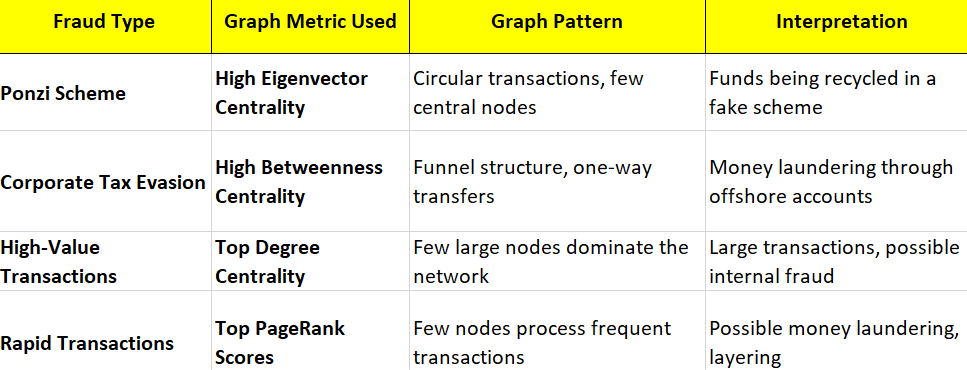